In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

import IPython.core.display as di

di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

## import data

In [3]:
def importdata(path):
    
    df = pd.read_csv(path)
    display(df.isnull().sum())
    
    print('Number of Original Dataset : %d' % (df.shape[0]))
    df = df.dropna(axis = 0)
    print('Number of Drop NaN : %d' % (df.shape[0]))
    df = df.reset_index(drop = True)
    
    con0 = pd.DataFrame(df.Sport.str.split('x',2).tolist(), columns = ['Sport','y'])
    con1 = pd.DataFrame(df.Dport.str.split('x',2).tolist(), columns = ['Dport','w'])
    del df["Sport"]
    del df["Dport"]
    df["Sport"] = con0.Sport
    df["Dport"] = con1.Dport
    return df

In [4]:
path_trianing = "capture20110810.binetflow.txt"
df_drop = importdata(path_trianing)

StartTime         0
Dur               0
Proto             0
SrcAddr           0
Sport          9379
Dir               0
DstAddr           0
Dport          4390
State             1
sTos          10590
dTos         195190
TotPkts           0
TotBytes          0
SrcBytes          0
Label             0
dtype: int64

Number of Original Dataset : 2824636
Number of Drop NaN : 2619340


In [5]:
def preprocessing(df):
    ### labeling
    condition = (df.SrcAddr != "147.32.84.165") & (df.DstAddr != "147.32.84.165")
    bot = df[~condition]
    nonbot = df[condition]
    bot["label"] = 1
    nonbot["label"] = 0
    df2 = pd.concat([bot, nonbot])
    df3 = df2.drop(["Label"], axis=1)
    df3 = df3.sort(columns = "StartTime", axis = 0, ascending = True)
    print('Number of Botnet : %d' % (bot.shape[0]))
    print('Number of Normal : %d' % (nonbot.shape[0]))
    
    ### category
    df3.StartTime = df3.StartTime.astype("category").cat.codes
    df3.Proto = df3.Proto.astype("category").cat.codes
    df3.Dir = df3.Dir.astype("category").cat.codes
    df3.State = df3.State.astype("category").cat.codes
    return df3

In [6]:
df = preprocessing(df_drop)
df.head()

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Number of Botnet : 28324
Number of Normal : 2591016


,StartTime,Dur,Proto,SrcAddr,Dir,DstAddr,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Sport,Dport,label
0,0,3550.182373,4,212.50.71.179,3,147.32.84.229,6,0.0,0.0,12,875,413,39678,13363,0
1,1,0.000883,4,84.13.246.132,3,147.32.84.229,6,0.0,0.0,2,135,75,28431,13363,0
2,2,0.000326,3,217.163.21.35,5,147.32.86.194,9,0.0,0.0,2,120,60,80,2063,0
3,3,0.056966,3,83.3.77.74,5,147.32.85.5,10,0.0,0.0,3,180,120,32882,21857,0
4,4,3427.768066,4,74.89.223.204,3,147.32.84.229,6,0.0,0.0,42,2856,1596,21278,13363,0


         SrcAddr          Dur
0  1.108.169.143    64.778000
1      1.11.9.68    10.804866
2     1.112.1.75     0.001425
3  1.112.109.236     0.001318
4  1.112.111.184  1531.073574
0.000920    562
0.000925    554
0.001000    551
0.000926    545
0.000915    537
Name: Dur, dtype: int64


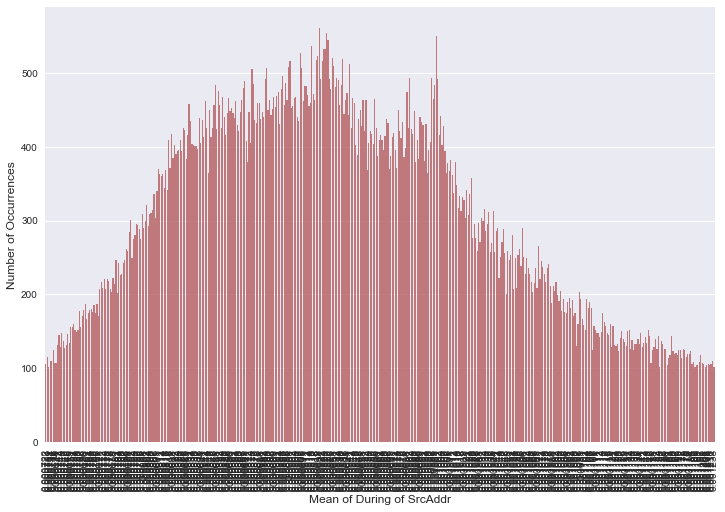

In [7]:
cnt_srs = df.groupby("SrcAddr")["Dur"].aggregate("mean").reset_index()
print(cnt_srs.head())
cnt_srs = cnt_srs.Dur.value_counts()
cnt_srs = cnt_srs[(cnt_srs.values > 100)]
print(cnt_srs.head())

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Mean of During of SrcAddr', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [8]:
cnt_srs = df.groupby("DstAddr")["Dur"].aggregate("max").reset_index()
print(cnt_srs.shape)
print(cnt_srs.head())
cnt_srs = cnt_srs.Dur.value_counts()
print(cnt_srs.head())

(77036, 2)
         DstAddr          Dur
0   1.160.233.95  3039.922363
1  1.160.235.169  3473.759521
2   1.160.28.125     0.350306
3    1.160.73.79  3379.878174
4    1.160.75.74  1866.979126
2198.760498    11
2198.760742    11
2198.761230     9
2198.812500     6
2198.756104     6
Name: Dur, dtype: int64


         DstAddr   Dur
0   1.160.233.95  3039
1  1.160.235.169  3473
2   1.160.28.125     0
3    1.160.73.79  3379
4    1.160.75.74  1866
0       24772
1        1210
2         439
3599      359
3         270
Name: Dur, dtype: int64
Shape of restricted counts 701


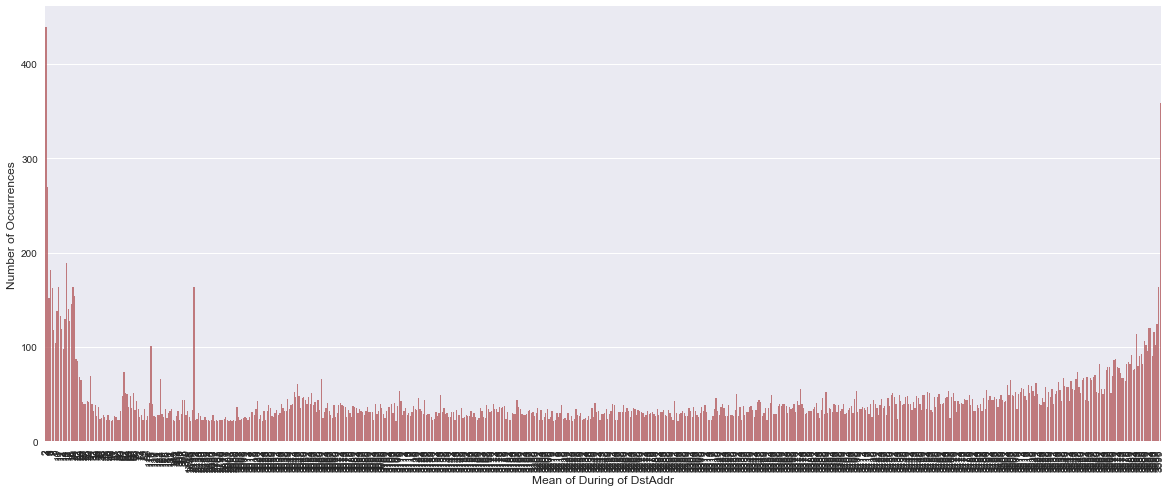

In [9]:
cnt_srs = df.groupby("DstAddr")["Dur"].aggregate("max").reset_index()
cnt_srs.Dur = pd.to_numeric(cnt_srs.Dur, errors = 'coerce')
cnt_srs["Dur"] = cnt_srs["Dur"].astype(int)
print(cnt_srs.head())
cnt_srs = cnt_srs.Dur.value_counts()
print(cnt_srs.head())
cnt_srs = cnt_srs[(cnt_srs.values > 20) & (cnt_srs.values < 1200)]
print("Shape of restricted counts", cnt_srs.shape[0])

plt.figure(figsize=(20,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha = 0.8, color = color[2])
plt.ylabel('Number of Occurrences', fontsize = 12)
plt.xlabel('Mean of During of DstAddr', fontsize = 12)
plt.xticks(rotation = 'vertical')
plt.show()

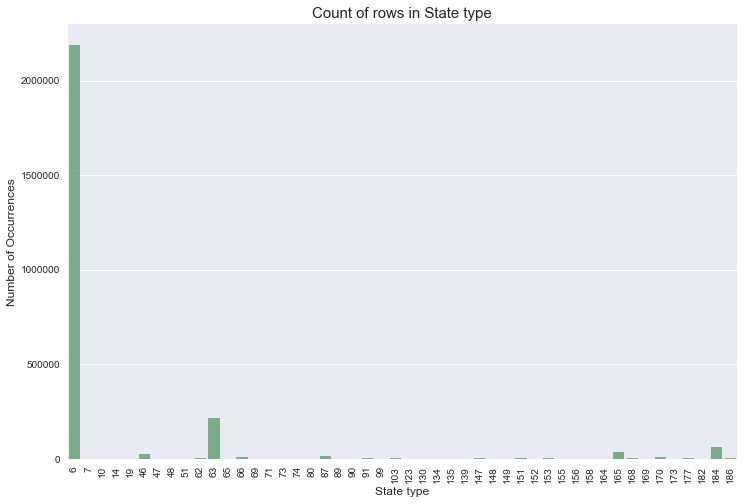

In [10]:
cnt_srs = df.State.value_counts()
cnt_srs = cnt_srs[cnt_srs.values > 100] ########
#print(cnt_srs)

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('State type', fontsize=12)
plt.title('Count of rows in State type', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

0.0    2616539
2.0       1310
3.0        888
1.0        603
Name: sTos, dtype: int64


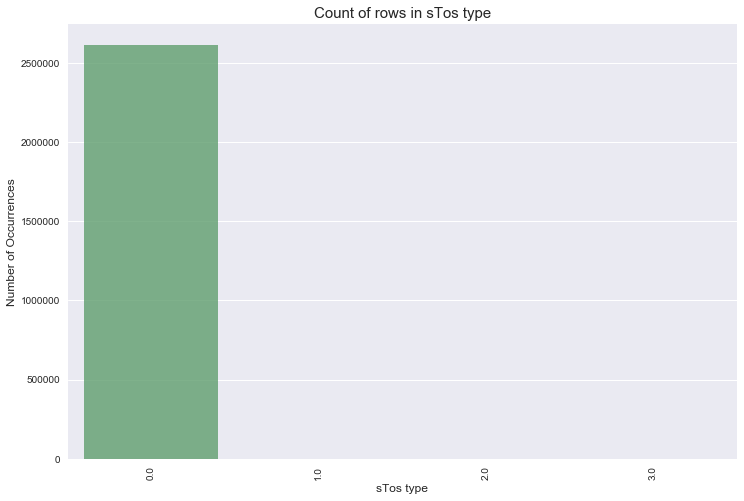

In [11]:
cnt_srs = df.sTos.value_counts()
print(cnt_srs)

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sTos type', fontsize=12)
plt.title('Count of rows in sTos type', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

4    2185636
3     427336
2       2562
1       2256
0       1541
5          9
Name: Proto, dtype: int64


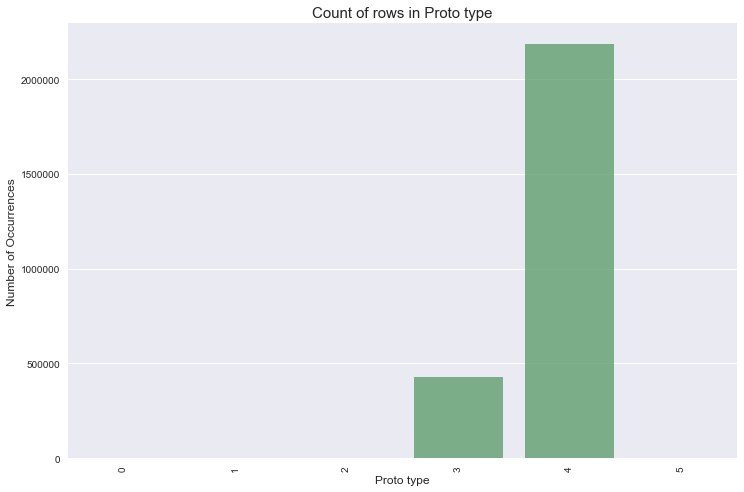

In [12]:
cnt_srs = df.Proto.value_counts()
print(cnt_srs)

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Proto type', fontsize=12)
plt.title('Count of rows in Proto type', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

## kmeans

In [13]:
print(df.shape)
df_clu = df.drop(["label", "StartTime", "SrcAddr", "DstAddr"], axis = 1)
df_clu.head()

(2619340, 15)


,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Sport,Dport
0,3550.182373,4,3,6,0.0,0.0,12,875,413,39678,13363
1,0.000883,4,3,6,0.0,0.0,2,135,75,28431,13363
2,0.000326,3,5,9,0.0,0.0,2,120,60,80,2063
3,0.056966,3,5,10,0.0,0.0,3,180,120,32882,21857
4,3427.768066,4,3,6,0.0,0.0,42,2856,1596,21278,13363


In [14]:
sc = StandardScaler()
Z = sc.fit_transform(df_clu)

kmeans = KMeans(n_clusters = 2, random_state = 0,
                algorithm = 'full', tol = 1e-4, precompute_distances = False)
kmeans.fit(Z)
y_kmeans = kmeans.predict(Z)

## DBscan

In [15]:
#bdscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', algorithm='auto', leaf_size=30, p=None, n_jobs=1)
# bdscan.fit(Z)
#y_dbscan = bdscan.fit_predict(Z)

## PCA (dimension reduction)

In [16]:
def pca(Z):
    ### variance and covariance matrix
    C = np.dot(Z.T, Z) / df_drop.shape[0]
    eigen_vals, eigen_vecs = np.linalg.eigh(C)
    print('\nEigenvalues: \n%s' % eigen_vals)
    ### 累積解釋程度圖
    tot = sum(np.abs(eigen_vals))
    var_exp = [(i / tot) for i in sorted(np.abs(eigen_vals), reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    plt.bar(range(1, eigen_vals.size + 1), var_exp, alpha=0.5, align='center',
            label='Individual')
    plt.step(range(1, eigen_vals.size + 1), cum_var_exp, where='mid',
             label='Cumulative')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    ### projection
    eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
    eigen_pairs.sort(reverse=True)

    P = np.hstack((eigen_pairs[0][1][:, np.newaxis],
                   eigen_pairs[1][1][:, np.newaxis]))
    Z_pca = Z.dot(P)
    return Z_pca


Eigenvalues: 
[ 0.00928188  0.08585327  0.20210503  0.48441019  0.65135292  0.80199088
  0.98174933  1.01661277  1.52668998  2.50331887  2.73663487]


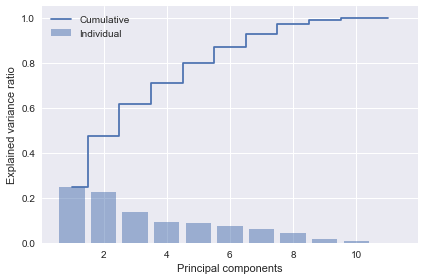

In [17]:
Z_pca = pca(Z)

In [18]:
def pca_kmeans_plot(Z_pca, y_kmeans):
    result_pca = pd.DataFrame(np.hstack([Z_pca, y_kmeans.reshape(y_kmeans.shape[0], 1)]))
    result_pca.columns = ['first', 'second', "label_kmeans"]
    print(result_pca['label_kmeans'].value_counts())
    print('PCA Data:')
    print(result_pca.head())
    ### plot
    result_pca[(result_pca.second < 10)].plot.scatter(x='first', y='second',
                                                  c='label_kmeans', s = 5, colormap='brg')
    plt.show()
    return result_pca

1.0    2191725
0.0     427615
Name: label_kmeans, dtype: int64
PCA Data:
      first    second  label_kmeans
0 -1.200074  0.167793           1.0
1 -0.671482  0.069018           1.0
2 -0.177275  0.014016           1.0
3 -0.274776  0.031309           1.0
4 -1.189513  0.177099           1.0


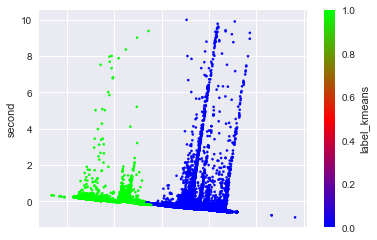

In [19]:
result_pca = pca_kmeans_plot(Z_pca, y_kmeans)

> plot of "PCA + kmeans"

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 425438 2165578]
 [   2177   26147]]
Normalized confusion matrix
[[ 0.16  0.84]
 [ 0.08  0.92]]


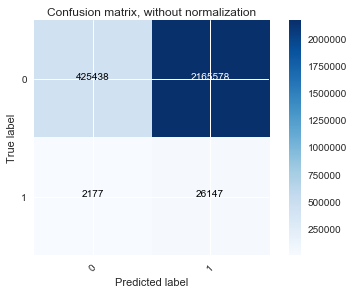

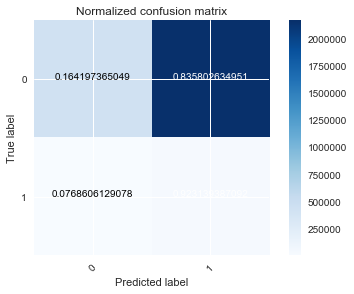

In [21]:
from sklearn.metrics import confusion_matrix
import itertools

y_true = df["label"]
y_pred = result_pca["label_kmeans"]
cm = confusion_matrix(y_true, y_pred, labels = None, sample_weight = None)

np.set_printoptions(precision=2)
class_names = ["0", "1"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names,
                      title = 'Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names, normalize = True,
                      title = 'Normalized confusion matrix')

plt.show()

# Testing 

In [22]:
path_testing = "capture20110811.binetflow.txt"
df_drop = importdata(path_testing)

StartTime         0
Dur               0
Proto             0
SrcAddr           0
Sport          3993
Dir               0
DstAddr           0
Dport          2973
State             0
sTos           4324
dTos         269835
TotPkts           0
TotBytes          0
SrcBytes          0
Label             0
dtype: int64

Number of Original Dataset : 1808122
Number of Drop NaN : 1534307


In [23]:
df = preprocessing(df_drop)
df.head()

/Users/Shawn/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Number of Botnet : 7733
Number of Normal : 1526574


,StartTime,Dur,Proto,SrcAddr,Dir,DstAddr,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Sport,Dport,label
0,0,2069.973145,4,203.253.8.233,3,147.32.84.229,7,0.0,0.0,3,197,123,30533,13363,0
1,1,895.989258,3,81.47.154.13,4,147.32.84.229,119,0.0,0.0,70,7032,4501,49200,13363,0
2,2,3561.927246,4,147.32.84.229,3,113.128.219.130,7,0.0,0.0,63,15770,13419,13363,59790,0
3,3,3511.664551,3,147.32.84.229,4,155.56.68.217,101,0.0,0.0,1352,143873,64239,443,60992,0
4,4,3539.911621,3,195.47.34.216,4,147.32.84.229,101,0.0,0.0,333,34386,21938,28508,13363,0


In [24]:
print(df.shape)
df_clu = df.drop(["label", "StartTime", "SrcAddr", "DstAddr"], axis = 1)
df_clu.head()

(1534307, 15)


,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Sport,Dport
0,2069.973145,4,3,7,0.0,0.0,3,197,123,30533,13363
1,895.989258,3,4,119,0.0,0.0,70,7032,4501,49200,13363
2,3561.927246,4,3,7,0.0,0.0,63,15770,13419,13363,59790
3,3511.664551,3,4,101,0.0,0.0,1352,143873,64239,443,60992
4,3539.911621,3,4,101,0.0,0.0,333,34386,21938,28508,13363



Eigenvalues: 
[ 0.01  0.08  0.23  0.56  0.71  0.73  0.98  1.02  1.63  2.27  2.79]


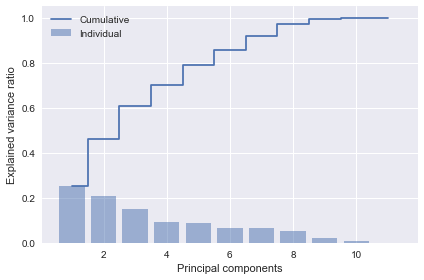

1.0    1285006
0.0     249301
Name: label_kmeans, dtype: int64
PCA Data:
      first    second  label_kmeans
0 -1.002710  0.138355           1.0
1  1.805922 -0.166837           0.0
2 -1.836091  0.359309           1.0
3  0.635070  0.406893           1.0
4  1.198830  0.034199           1.0


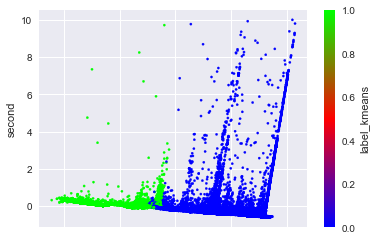

In [27]:
### kmeans
sc = StandardScaler()
Z = sc.fit_transform(df_clu)
y_kmeans = kmeans.predict(Z)
### pca plot
Z_pca = pca(Z)
result_pca = pca_kmeans_plot(Z_pca, y_kmeans)

Confusion matrix, without normalization
[[ 242361 1284213]
 [   6940     793]]
Normalized confusion matrix
[[ 0.16  0.84]
 [ 0.9   0.1 ]]


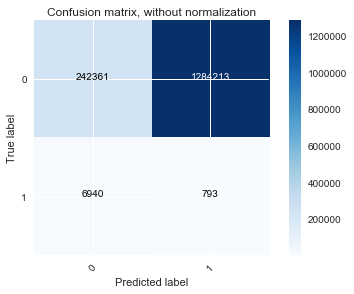

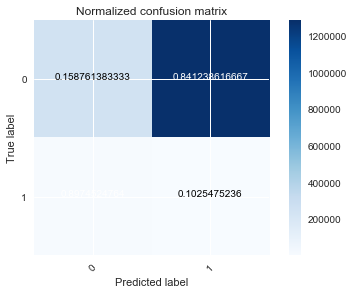

In [26]:
from sklearn.metrics import confusion_matrix
import itertools

y_true = df["label"]
y_pred = pd.DataFrame(y_kmeans)
cm = confusion_matrix(y_true, y_pred, labels = None, sample_weight = None)

np.set_printoptions(precision = 2)
class_names = ["0", "1"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names,
                      title = 'Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes = class_names, normalize = True,
                      title = 'Normalized confusion matrix')

plt.show()